# チョコボールの内容量を推定する

In [1]:
# ライブラリのインポート
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# プロットする図を綺麗にする
sns.set()

## 仮定
- 実施キャンペーン、時期によって重量は変化しないものと考える

## データを確認する


In [3]:
# データの読み込み
data_raw = pd.read_csv('../data/chocoball_raw.csv')
tastes = pd.read_csv('../data/choco_tastes.csv')

print('data_raw.shape:', data_raw.shape)
print('tastes.shape:', tastes.shape)

data_raw.shape: (467, 9)
tastes.shape: (13, 4)


In [4]:
data_raw.head()

,No.,measure_date,best_before,weight,box_weight,ball_number,angel,campaign,taste
0,1,2017-11-19,NaN,34.002,4.756,16,0,1,0
1,2,2017-11-20,NaN,34.435,4.805,17,0,1,0
2,3,2017-11-21,2018-06-01,34.000,4.815,18,0,1,0
3,4,2017-11-22,2018-06-01,34.193,4.818,17,0,1,0
4,5,2017-11-23,2018-06-01,35.344,4.836,16,0,1,0


In [5]:
tastes.head()

,id,name,name_en,spec
0,0,ピーナツ,peanut,28
1,1,いちご,strawberry,25
2,2,金のきなこもち,kinako,29
3,3,レモングミ,lemon,29
4,4,甘酒,amazake,22


### データの加工
- 正味重量（weight - box_weight）を作る
- 内容量(spec)をまとめて一つのDataFrameを作る

In [6]:
# 正味重量（weight - box_weight）を作る
data_raw['net_weight'] = data_raw['weight'] - data_raw['box_weight']
data_raw.head()

,No.,measure_date,best_before,weight,box_weight,ball_number,angel,campaign,taste,net_weight
0,1,2017-11-19,NaN,34.002,4.756,16,0,1,0,29.246
1,2,2017-11-20,NaN,34.435,4.805,17,0,1,0,29.630
2,3,2017-11-21,2018-06-01,34.000,4.815,18,0,1,0,29.185
3,4,2017-11-22,2018-06-01,34.193,4.818,17,0,1,0,29.375
4,5,2017-11-23,2018-06-01,35.344,4.836,16,0,1,0,30.508


In [7]:
# 内容量(spec)をまとめて一つのDataFrameを作る
df_data = pd.merge(data_raw, tastes, left_on=['taste'], right_on=['id'], how='left')
df_data = df_data.loc[:, ['measure_date', 'campaign', 'taste', 'name_en', 'angel', 'net_weight', 'spec']]
df_data.head()

,measure_date,campaign,taste,name_en,angel,net_weight,spec
0,2017-11-19,1,0,peanut,0,29.246,28
1,2017-11-20,1,0,peanut,0,29.630,28
2,2017-11-21,1,0,peanut,0,29.185,28
3,2017-11-22,1,0,peanut,0,29.375,28
4,2017-11-23,1,0,peanut,0,30.508,28


### データの基礎統計量確認

#### フレーバー毎の計測データ数

In [8]:
df_data.groupby(['name_en']).count()[['net_weight']].sort_values(by='net_weight', ascending=False)

,net_weight
name_en,
peanut,344
strawberry,34
banana,20
m-caramel,16
pineapple,11
amazake,10
pachipachi,10
custard,5
kinako,5


データ数にばらつきがあるので、ある程度データ数が多いフレーバーを解析対象とする。

発展的な内容として、統計モデリングの枠組みにおいては、データ数が少ない場合の予測方法はある。
しかし、今回は対象外とする。

In [9]:
df_data_sel = df_data.query('name_en in ["peanut", "strawberry", "banana"]')
grp = df_data_sel.groupby(['name_en'])

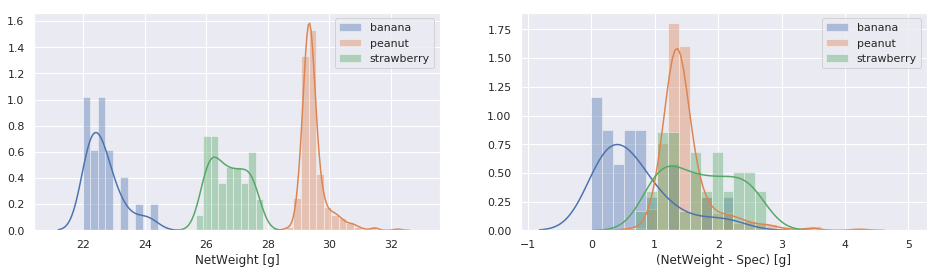

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=np.linspace(21, 33, 50), hist=True, label=key, ax=ax[0])
    sns.distplot((value["net_weight"] - value["spec"]), bins=bins, hist=True, label=key, ax=ax[1])
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()

この図は、左が正味重量のヒストグラム。
右が、マージンのヒストグラム。

## 最尤推定でパラメータを推定する

### モデル設定
- (スライド参照)
- 正味重量は正規分布に従うと仮定
  - 正規分布のパラメータは平均$\mu$と分散$\sigma^2$の二つのパラメータ
  - 平均値$\mu$は仕様上の内容量$spec$にマージン$\alpha$を足したものとする(下記)
    - $\mu = spec + \alpha$
  - チョコボールの購入数（試行数）を$N$とし、データを$X=\{x_1, x_2, \cdots , x_n\}$と表記する
$$
f(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp{\{-\frac{(x-\mu)^2}{2\sigma^2}\}}
$$

### 最尤推定量の計算
- (スライド参照)
- 求めたいパラメータは正味重量の平均$\mu$と分散$\sigma^2$
- 最尤推定では、対数尤度$\log{L(\mu, \sigma^2|X)}$をパラメータ($\mu, \sigma^2$)で偏微分して0となる値を推定値とする
　　- 正規分布のパラメータは2つあるため、偏微分して0となる2つの方程式を解くことになる

$$
L(\mu, \sigma^2|X) = \prod^{N}_{i=1}{f(x|\mu, \sigma^2)} = \prod^{N}_{i=1}{\frac{1}{\sqrt{2\pi\sigma^2}}exp{\{-\frac{(x-\mu)^2}{2\sigma^2}\}}}\\
\log{L(\mu, \sigma^2|X)} = N\log{\frac{1}{\sqrt{2\pi\sigma^2}}} + 
\sum^{N}_{i=1}{(-\frac{(x_i-\mu)^2}{2\sigma^2})}\\
\qquad\qquad\qquad
= -\frac{N}{2}\log{(2\pi\sigma^2)} - \frac{1}{2\sigma^2}\sum^{N}_{i=1}{(x_i-\mu)^2}
$$

$\mu$と$\sigma^2$でそれぞれ偏微分して0と置くと最尤推定量が算出できる。


最初に平均$\mu$から、
$$
\frac{\partial L}{\partial \mu} = -\frac{1}{\sigma^2}\sum{(x_i-\mu)^2} = 0 \\
\mu = \frac{1}{N}\sum{x_i}
$$

次に、分散$\sigma^2$、
$$
\frac{\partial L}{\partial \sigma^2} 
= -\frac{N}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum{(x_i-\mu)^2} = 0 \\
\sigma^2 = \frac{1}{N}\sum{(x_i-\mu)^2}
$$

ということで、長々と数式を展開してきたが、結局はこちらも標本平均と標本分散となる。

In [11]:
# フレーバー毎にグループ分けをする
grp = df_data_sel.groupby(['name_en'])
# フレーバーのマスタDataFrameのindexを変更
tastes_spec = tastes.set_index('name_en')

# 統計量を計算
mu_mse = grp.mean()['net_weight']
mu_mse.name = 'mu'
sig2_mse = grp.var()['net_weight']
sig2_mse.name = 'sig2'

# αの算出
alpha = dict()
for taste, mu in mu_mse.items():
    alpha[taste] = mu - tastes_spec.loc[taste, 'spec']
alpha_s = pd.Series(alpha, name='alpha')

# 結果をまとめる
df_mse = pd.concat([mu_mse, alpha_s, sig2_mse], axis=1)
df_mse

,mu,alpha,sig2
name_en,,,
banana,22.670850,0.670850,0.330297
peanut,29.480142,1.480142,0.173707
strawberry,26.723735,1.723735,0.317978


### 推定値の活用

最尤推定量を計算することができたので、推定結果をデータに当てはめてみる

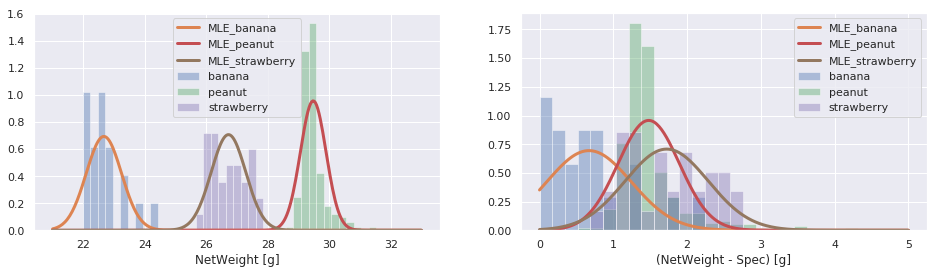

In [12]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins_p = np.linspace(21, 33, 50)
bins_a = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=bins_p, kde=False, hist=True, norm_hist=True, label=key, ax=ax[0])
    x1 = np.linspace(min(bins_p), max(bins_p), 300)
    y1 = stats.norm.pdf(x1, loc=df_mse.loc[key, 'mu'], scale=math.sqrt(df_mse.loc[key, 'sig2']))
    ax[0].plot(x1, y1, lw=3, label='MLE_{}'.format(key))
    
    sns.distplot((value["net_weight"] - value["spec"]), bins=bins_a, kde=False, hist=True, norm_hist=True, label=key, ax=ax[1])
    x2 = np.linspace(min(bins_a), max(bins_a), 300)
    y2 = stats.norm.pdf(x2, loc=df_mse.loc[key, 'alpha'], scale=math.sqrt(df_mse.loc[key, 'sig2']))
    ax[1].plot(x2, y2, lw=3, label='MLE_{}'.format(key))
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()

plt.savefig('net_weight_mle.png')

この結果から、ピーナツとイチゴ味は仕様よりも1.5g程度多く入っているらしいということがわかった。  
また、チョコバナナ味は他の2つと傾向が異なり、仕様に近い重さしか無い(マージンが少ない)こともわかった。

この差は何でしょう？

## ベイズ推定でパラメータを推定する

### モデル設定
- (スライド資料参照)
- ベイズの式を再度思い出す
    - $p(\theta | x) \propto p(x | \theta)p(\theta)$
    - x : チョコボールの重量データ
    - $\theta$ : 確率分布のパラメータ
    - 尤度$p(x | \theta)$と事前分布$p(\theta)$を設定する必要がある
- 尤度関数
    - 最尤推定と同様に、正規分布を採用
    - $p(x | \theta) = N(\mu, \sigma^2)$
      - なお, $\mu=spec+\alpha$
    - 推定するパラメータは二つ
      - $\alpha$ : 平均のマージン
      - $\sigma^2$ : 分散
- 事前分布
    - 推定するパラメータ毎にそのパラメータの事前分布を設定する必要がある
    - マージン$\alpha$の事前分布には正規分布
      - $p(\alpha) = N(\mu_a, \sigma^2_a)$
    - 分散$\sigma^2$の事前分布には半正規分布
      - $p(\sigma^2) = HalfNormal(sigma^2_b)$

#### 正規分布の形状をみてみよう

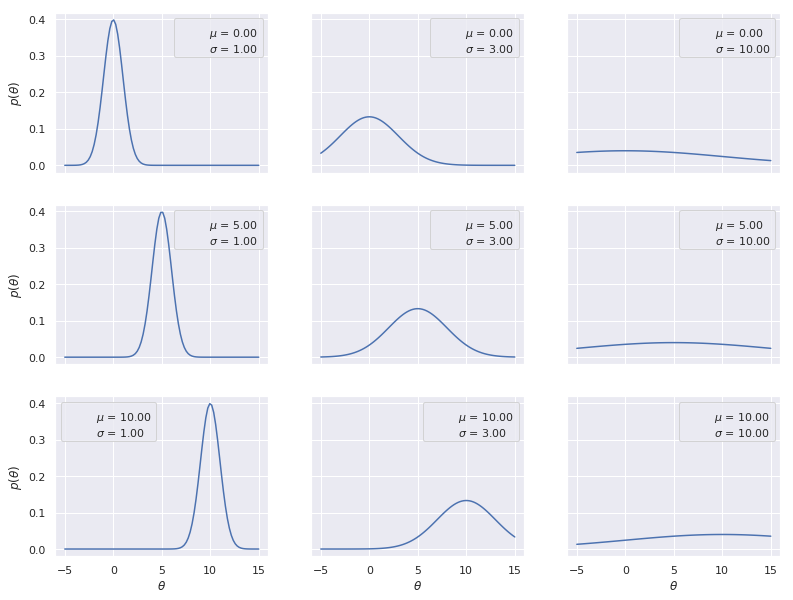

In [13]:
params_mu = [0, 5, 10] # 平均値
params_sig = [1, 3, 10] # 標準偏差

x = np.linspace(-5, 15, 100)

fig = plt.figure(figsize=(13, 10))
ax = fig.subplots(len(params_mu), len(params_sig), sharex=True, sharey=True)
cnt=0
for i in range(len(params_mu)):
    for j in range(len(params_sig)):
        mu = params_mu[i]
        sig = params_sig[j]
        y = stats.norm(mu, sig).pdf(x)
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="$\\mu$ = {:3.2f}\n$\\sigma$ = {:3.2f}".format(mu, sig), alpha=0)
        ax[i, j].legend()
        if i == (len(params_mu)-1):
            ax[i,j].set_xlabel('$\\theta$')
        if j == 0:
            ax[i,j].set_ylabel('$p(\\theta)$')
plt.savefig('norm_dist_var.png')

### 解析的な計算方法(共役事前分布)

エンゼルの出現確率を予測した際に、解析的に計算ができることを示した。  
重量推定のモデルでも同様に計算することができる。

尤度関数は正規分布を利用するので、その共役事前分布を事前分布に選ぶことで解析的に計算ができる。
ここでは計算は省略するが、正規分布の共役事前分布は正規分布である。

### 数値的な計算方法(MCMC)

#### 計算の実行
実際の計算は、エンゼル出現確率の予測と同様にMCMCを利用して、数値的に計算する。

In [14]:
taste = df_data_sel['taste'].values
taste_idx = pd.Categorical(df_data_sel['taste']).codes
tastes_id = tastes.set_index('id')
spec_lst = np.array([tastes_id.loc[i, 'spec'] for i in set(taste)])
print(set(taste))
print(set(taste_idx))
print(spec_lst)

{0, 1, 12}
{0, 1, 2}
[28 25 22]


In [15]:
d_weight = df_data_sel['net_weight'].values
n_sample = 10000

with pm.Model() as model_weight:
    # 事前分布の設定
    alpha = pm.Normal('alpha', mu=0, sd=20, shape=len(set(taste_idx)))
    #alpha = pm.HalfNormal('alpha', sd=10, shape=len(set(taste_idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(taste_idx)))
    # 正規分布のパラメータμを計算(μ自体は確率的に変動しないのでDeterministic宣言)
    mu = pm.Deterministic('mu', spec_lst[taste_idx]+alpha[taste_idx])
    #mu = pm.Deterministic('mu', spec_lst[taste_idx]*alpha[taste_idx])
    
    weights = pm.Normal('weights', mu=mu, sd=sds[taste_idx], observed=d_weight)
    
    trace = pm.sample(n_sample, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:29<00:00, 1426.05draws/s]


### 結果の解釈

推定対象である、正規分布のパラメータ$\mu, \sigma$の事後分布を確認する。
なお、以下の図はchain数（MCMCサンプル系列の数）分の結果が同時に表示されている。
- 左図:パラメータの事後分布
- 右図:パラメータのサンプル系列。ランダムにサンプルされていることが望ましい。

/Users/tok41/workspace/seminar_choco/env_sc/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1353e28d0>,
      dtype=object)

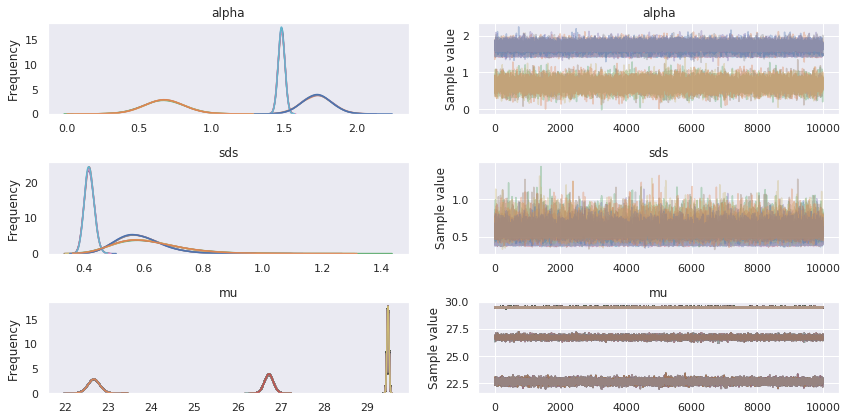

In [16]:
pm.traceplot(trace)

次に、統計量を確認する

In [17]:
pm.summary(trace, varnames=['alpha'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.480326,0.022516,0.000106,1.435675,1.523764,45224.369637,0.999951
alpha__1,1.723605,0.101624,0.000558,1.519306,1.918641,42031.852832,1.000028
alpha__2,0.672128,0.140611,0.000768,0.392760,0.947378,34133.644745,1.000061


- mean:事後分布の期待値
- sd:サンプルの標本標準偏差
- mc_error:サンプリングに起因する誤差の推定値
- hpd_2.5:95%信用区間の下限
- hpd_97.5:95%信用区間の上限
- n_eff:サンプルサイズの効果量
- Rhat:chain間の分散とchain内の分散の比のようなもの。1に近いほど良い。大きい場合は、収束していないchainがある。

chainを全て統合して、事後分布を推定。

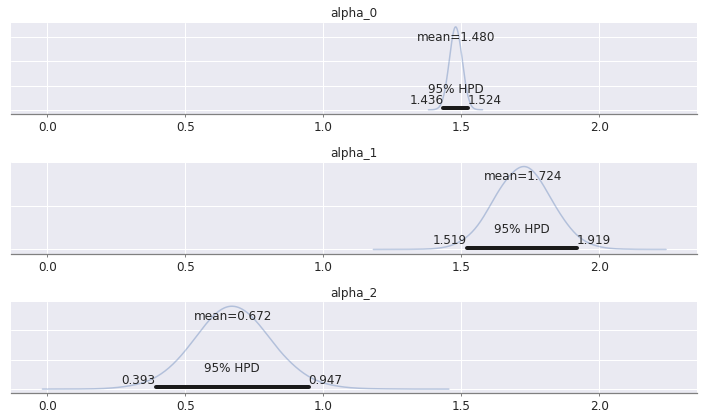

In [18]:
alpha_mse = [df_mse.loc[tastes_id.loc[t, 'name_en'], 'alpha'] 
             for t in set(taste)]

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(3, 1, sharex=True)

pm.plot_posterior(trace, varnames=['alpha'], 
                  kde_plot=True, alpha_level=0.05, ax=ax)
#pm.plot_posterior(trace, varnames=['alpha'], 
#                  kde_plot=True, alpha_level=0.05, 
#                  ref_val=alpha_mse)
plt.savefig('posterior_weight_diff.png')

この結果から、マージン$\alpha$はフレーバーによって異なることがわかった。
特にチョコバナナ味は、他のフレーバーと比較して、マージン$\alpha$が小さいということがわかった。